In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
# Define the paths
training_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training'
testing_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing'

# Classes
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
# Function to count images in each class
def count_images_in_classes(base_path, classes):
    counts = {}
    for cls in classes:
        class_path = os.path.join(base_path, cls)
        counts[cls] = len(os.listdir(class_path))
    return counts



# Count images in training and testing sets

In [ ]:
training_counts = count_images_in_classes(training_path, classes)

In [ ]:
testing_counts = count_images_in_classes(testing_path, classes)

In [ ]:
print("Training set image counts:", training_counts)


Training set image counts: {'glioma': 1335, 'meningioma': 1353, 'notumor': 1595, 'pituitary': 1457}


In [ ]:
print("Testing set image counts:", testing_counts)

Testing set image counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [ ]:
# Plotting the distribution
def plot_distribution(counts, title):
    plt.figure(figsize=(10, 5))
    plt.bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title(title)
    plt.show()




# Plot distributions

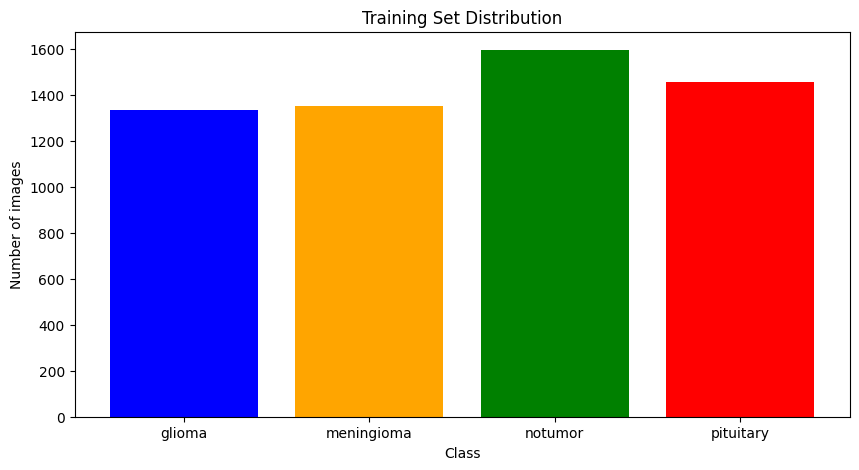

In [ ]:
plot_distribution(training_counts, 'Training Set Distribution')

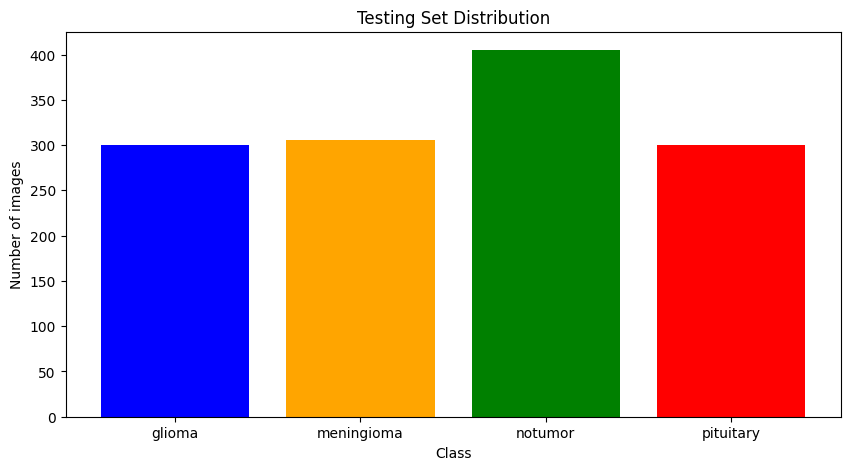

In [ ]:
plot_distribution(testing_counts, 'Testing Set Distribution')

In [ ]:
# Function to get image statistics
def get_image_stats(path):
    dimensions = []
    file_formats = []
    pixel_values = {cls: [] for cls in classes}

    for cls in classes:
        class_path = os.path.join(path, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                dimensions.append(img.size)
                file_formats.append(img.format)
                pixel_values[cls].extend(list(img.getdata()))

    return dimensions, file_formats, pixel_values

# Get stats for training set
train_dims, train_formats, train_pixels = get_image_stats(training_path)

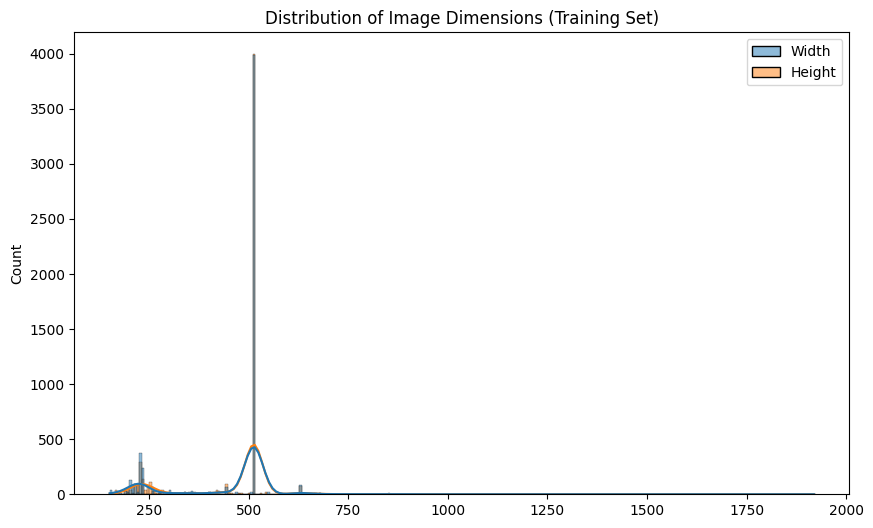

In [ ]:
# Analyze image dimensions
train_dims_df = pd.DataFrame(train_dims, columns=['Width', 'Height'])
plt.figure(figsize=(10, 6))
sns.histplot(train_dims_df, kde=True)
plt.title('Distribution of Image Dimensions (Training Set)')
plt.show()

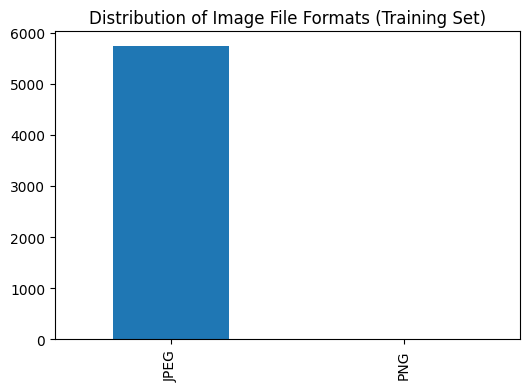

In [ ]:
# Analyze file formats
train_formats_df = pd.Series(train_formats).value_counts()
plt.figure(figsize=(6, 4))
train_formats_df.plot(kind='bar')
plt.title('Distribution of Image File Formats (Training Set)')
plt.show()

## Model Training

In [ ]:
!pip install scikeras[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.3 MB/s eta 0:00:00


# Model From Strach
## No.1

In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import RMSprop, Adamax, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator




In [ ]:
# Define image dimensions and paths
img_height, img_width = 128, 128
training_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training'
testing_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing'


In [ ]:
# Define data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)


Found 4593 images belonging to 4 classes.
Found 1147 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Verify class indices
print("Class indices in training data:", train_generator.class_indices)
print("Class indices in validation data:", validation_generator.class_indices)
print("Class indices in testing data:", test_generator.class_indices)

Class indices in training data: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class indices in validation data: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class indices in testing data: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
!pip install keras-tuner

In [ ]:
def model_s1(hp):
    # Choose optimizer
    optimizer = hp.Choice('optimizer', values=['rmsprop', 'adamax'])
    learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001])
    final_activation = hp.Choice('final_activation', values=['softmax', 'sigmoid'])

    if optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        opt = Adamax(learning_rate=learning_rate)

    model = Sequential([
        Conv2D(32, (2, 2), activation='relu', input_shape=(img_height, img_width, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (2, 2), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dense(4, activation=final_activation)
    ])

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


tuner = kt.Hyperband(
    model_s1,
    objective='val_accuracy',
    max_epochs=15,
    hyperband_iterations=1,
    directory='/content/drive/MyDrive/Umair',
    project_name='model_strach_01'
)


tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=12,
    callbacks=[early_stopping]
)

Reloading Tuner from /content/drive/MyDrive/Umair/model_strach_01/tuner0.json

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
adamax            |adamax            |optimizer
0.0001            |0.0001            |learning_rate
softmax           |sigmoid           |final_activation
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 762ms/step - accuracy: 0.7564 - loss: 1.1572 - val_accuracy: 0.3330 - val_loss: 1.9922
Epoch 2/2
138/144 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - accuracy: 0.9423 - loss: 0.1627

In [ ]:
import matplotlib.pyplot as plt
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)


In [ ]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,  # You might want to train for more epochs
    callbacks=[early_stopping]
)

In [ ]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


# Model From Strach
## No.2

### Prepare Images

In [ ]:
# Define image dimensions and paths
img_height, img_width = 256, 256
training_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Training'
testing_path = '/content/drive/MyDrive/Brain Tumor MRI Dataset/Testing'


In [ ]:
# Define data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

model_s2_t = train_datagen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

model_s2_v = train_datagen.flow_from_directory(
    training_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

model_s2_test = test_datagen.flow_from_directory(
    testing_path,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical'
)
